In [103]:
import pandas as pd
import re
import nltk
import spacy

nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangnaichuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zhangnaichuan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangnaichuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
path = "Scripts TBBT.csv"
df = pd.read_csv(path , sep = "," , skipinitialspace=True, engine="python")

df = df[df['person_scene'].str.contains('Amy')]
df

,episode_name,dialogue,person_scene
15116,Series 03 Episode 23 – The Lunar Excitation,Excuse me. I’m Amy Farrah Fowler. You’re Sheld...,Amy
15118,Series 03 Episode 23 – The Lunar Excitation,"If that was slang, I’m unfamiliar with it. If...",Amy
15120,Series 03 Episode 23 – The Lunar Excitation,"I don’t object to the concept of a deity, but...",Amy
15122,Series 03 Episode 23 – The Lunar Excitation,"Noted. Now, before this goes any further, you...",Amy
15124,Series 03 Episode 23 – The Lunar Excitation,"Tepid water, please.",Amy
...,...,...,...
54344,Series 10 Episode 24 – The Long Distance Disso...,I was missing you again.,Amy
54346,Series 10 Episode 24 – The Long Distance Disso...,She’s what?,Amy
54348,Series 10 Episode 24 – The Long Distance Disso...,Hi.,Amy
54350,Series 10 Episode 24 – The Long Distance Disso...,Uh-huh. Hang on. (answering phone) Hello. A l...,Amy


In [105]:
data = df['dialogue']
data

15116    Excuse me. I’m Amy Farrah Fowler. You’re Sheld...
15118     If that was slang, I’m unfamiliar with it. If...
15120     I don’t object to the concept of a deity, but...
15122     Noted. Now, before this goes any further, you...
15124                                 Tepid water, please.
                               ...                        
54344                             I was missing you again.
54346                                          She’s what?
54348                                                  Hi.
54350     Uh-huh. Hang on. (answering phone) Hello. A l...
54352                                  It’s not important.
Name: dialogue, Length: 3420, dtype: object

In [106]:
def clean_text(text):
    # clean punctuation
    text = re.sub(r"[!”#$%&()*+,-.:;?@[\]^_`{|}~]", "", str(text))
    # lower
    return text.lower()

In [107]:
def process_words(text):
    # tokenization
    sentences = nltk.tokenize.sent_tokenize(text)
    words = nltk.tokenize.word_tokenize(text)
    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english') + ["i'm", "oh", "well"])
    filter_words = [word for word in words if word not in stop_words]
    # stemming
    porter = nltk.stem.PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filter_words]
    return {
        "sentences" : sentences,
        "filtered_words" : filter_words,
        "stemmed_words" : stemmed_words
    }

In [108]:
def pos_ner(text):
    doc = nlp(text)
    pos_tag = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return {
        "pos_tags": pos_tag,
        "entities" : entities
    }

In [109]:
processed_data = []
for text in data:
    cleaned = clean_text(text)
    processed = process_words(cleaned)
    ner_pos = pos_ner(" ".join(processed["filtered_words"]))
    processed_data.append({
        "org_text": text,
        "cleaned_text": cleaned,
        "filtered_words": processed["filtered_words"],
        "stemmed_words": processed["stemmed_words"],
        "pos_tags": ner_pos["pos_tags"],
        'entities': ner_pos['entities']
    }
    )

In [110]:
for i, data in enumerate(processed_data):
    if "pos_tags" not in data:
        print(f"Missing 'pos_tags' in entry {i}: {data}")

In [111]:
df['filtered_words'] = [data['filtered_words'] for data in processed_data]
df['stemmed_words'] = [data['stemmed_words'] for data in processed_data]
df['pos_tags'] = [data["pos_tags"] for data in processed_data]
df['entities'] = [data['entities'] for data in processed_data]


In [112]:
df.to_csv('processed_data.csv', index=False)

In [113]:
# Question 3

df['season'] = df['episode_name'].str.extract(r'Series (\d+)').astype(int)
df['episode'] = df['episode_name'].str.extract(r'Episode (\d+)').astype(int)
df['season_episode'] = df['season'].astype(str) + '-' + df['episode'].astype(str)
dialogue_list = df['filtered_words'].sum()

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dialogue_list)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [115]:
import numpy as np

def get_top_words(tfidf_matrix, feature_names, top_n=3):
    scores = np.sum(tfidf_matrix, axis=0).A1  # Sum TF-IDF scores across rows
    top_indices = np.argsort(scores)[::-1][:top_n]
    return [(feature_names[i], scores[i]) for i in top_indices]


In [116]:
total_tfidf_matrix = tfidf_vectorizer.fit_transform(dialogue_list)
top_10_words = get_top_words(tfidf_matrix, feature_names, top_n=50)
for i, word in enumerate(top_10_words):
    print(f"Top {i+1} Words:", word[0])

Top 1 Words: sheldon
Top 2 Words: know
Top 3 Words: like
Top 4 Words: get
Top 5 Words: one
Top 6 Words: okay
Top 7 Words: think
Top 8 Words: go
Top 9 Words: right
Top 10 Words: want
Top 11 Words: really
Top 12 Words: good
Top 13 Words: going
Top 14 Words: would
Top 15 Words: penny
Top 16 Words: let
Top 17 Words: got
Top 18 Words: na
Top 19 Words: could
Top 20 Words: gon
Top 21 Words: time
Top 22 Words: see
Top 23 Words: say
Top 24 Words: leonard
Top 25 Words: little
Top 26 Words: night
Top 27 Words: sure
Top 28 Words: sorry
Top 29 Words: come
Top 30 Words: yes
Top 31 Words: make
Top 32 Words: feel
Top 33 Words: back
Top 34 Words: us
Top 35 Words: take
Top 36 Words: maybe
Top 37 Words: mean
Top 38 Words: look
Top 39 Words: need
Top 40 Words: something
Top 41 Words: two
Top 42 Words: bernadette
Top 43 Words: never
Top 44 Words: thank
Top 45 Words: uh
Top 46 Words: said
Top 47 Words: first
Top 48 Words: nice
Top 49 Words: way
Top 50 Words: love


In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Grouping by Season
season_dialogues = df.groupby('season')['filtered_words'].apply(lambda x: ' '.join(sum(x, [])))
season_tfidf_matrix = tfidf_vectorizer.fit_transform(season_dialogues)

# Get top words for each season
for season, tfidf_matrix in enumerate(season_tfidf_matrix):
    top_words = get_top_words(tfidf_matrix, feature_names)
    print(f"Season {season + 3} Top Words:")
    for i in range(len(top_words)):
        print(i+1, top_words[i][0])
    print()


Season 3 Top Words:
1 soiled
2 baffled
3 unfamiliar

Season 4 Top Words:
1 like
2 sheldon
3 hoo

Season 5 Top Words:
1 like
2 sheldon
3 get

Season 6 Top Words:
1 sheldon
2 like
3 go

Season 7 Top Words:
1 sheldon
2 like
3 get

Season 8 Top Words:
1 sheldon
2 okay
3 know

Season 9 Top Words:
1 know
2 sheldon
3 okay

Season 10 Top Words:
1 sheldon
2 know
3 want



In [118]:
# Episode level
# Grouping by episode 
episode_dialogues = df.groupby('season_episode')['filtered_words'].apply(lambda x: ' '.join(sum(x, [])))
episode_tfidf_matrix = tfidf_vectorizer.fit_transform(episode_dialogues)

# Get top words for each episode 
episodes = df['season_episode'].unique()
for i, tfidf_matrix in enumerate(episode_tfidf_matrix):
    print(f"Episode {episodes[i]} Top Words:", get_top_words(tfidf_matrix, feature_names))
    print()

Episode 3-23 Top Words: [('disrespectful', 0.25876548768703617), ('hotter', 0.23915522113870036), ('airport', 0.23915522113870036)]

Episode 4-1 Top Words: [('selfish', 0.30218087701827634), ('keep', 0.20107967718267114), ('little', 0.19995556394325717)]

Episode 4-3 Top Words: [('scotch', 0.23486865685387173), ('trains', 0.21706938614770793), ('birthday', 0.1866413318976998)]

Episode 4-5 Top Words: [('blah', 0.4570175920643392), ('help', 0.1748499978270061), ('mother', 0.16630169782577217)]

Episode 4-8 Top Words: [('miss', 0.3353119733506522), ('bye', 0.2779953327347307), ('girls', 0.25148398001298916)]

Episode 4-10 Top Words: [('machine', 0.28393743686686124), ('smudge', 0.22840904941997542), ('looking', 0.22274973873286452)]

Episode 4-13 Top Words: [('choir', 0.24576810208061275), ('early', 0.22714282854062484), ('renaissance', 0.22714282854062484)]

Episode 4-14 Top Words: [('secrets', 0.23256096768064724), ('date', 0.20558104150251744), ('bert', 0.18480749767449609)]

Episode 

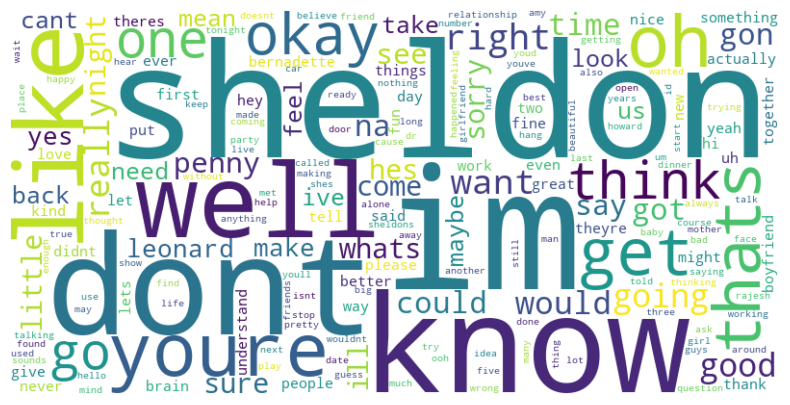

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(tfidf_matrix, feature_names):
    scores = np.sum(tfidf_matrix, axis=0).A1
    word_scores = {feature_names[i]: scores[i] for i in range(len(scores))}
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_wordcloud(total_tfidf_matrix, feature_names)